In [70]:
# load plotting library and src files
using PyPlot
include("./src/calcpml_2d.jl");
include("./src/yeeder.jl");
include("./src/fdfd.jl");

In [92]:
Nf = 100;
freqs = linspace(0.05,0.3,Nf);
#freqs = 0.085;
eps = 11.56;
L = 1;
spc = L/5.0;    
n = 500;
Nx2 = n;             Ny2 = n;
Nx = div(Nx2,2);     Ny = div(Ny2,2);
direct = zeros(Nf,1);
AVM = zeros(Nf,1);
dx = 0.01; dy = 0.01;
RES  = [dx dy];
ER2  = ones(Complex64,Nx2,Ny2);
MUR2 = ones(Complex64,Nx2,Ny2);
NPML = [40 40 40 40];
Pol = "Ez";
Q = zeros(Complex64,Nx,Ny);
BC = [-2,-2];
Is_d = zeros(Complex64,Nf,2);

Direct_s = zeros(Complex64,Nf,1);
AVM_s = zeros(Complex64,Nf,1);

d_eps = 0.01;
eps_vals = [eps-d_eps/2 eps+d_eps/2];
Ez = zeros(Complex64,Nx,Ny);
Ez_AJ = zeros(Complex64,Nx,Ny);

In [93]:
for fi in (1:Nf)  
    println(fi/Nf*100.0)
    freq = freqs[fi];
    lambda0 = 1/freq;
    
    #original simulation
    println("running original")
    e = eps;
    ER2[Nx-Int(L/dx):Nx+Int(L/dx),Ny-Int(L/dy):Ny+Int(L/dy)] = e;
    Q = zeros(Complex64,Nx,Ny);
    Q[Int(Nx/2)-Int(L/2/dx)-Int(spc/dx),Int(Ny/2)] = 1;
    (Ex,Ey,Ez,Hx,Hy,Hz) = fdfd(ER2,MUR2,RES,NPML,BC,lambda0,Pol,Q);
    E_obs = Ez[Int(Nx/2)+Int(L/2/dx)+Int(spc/dx),Int(Ny/2)];
    
    #adjoint simulation
    println("running adjoint")
    Q = zeros(Complex64,Nx,Ny);    
    Q[Int(Nx/2)+Int(L/2/dx)+Int(spc/dx),Int(Ny/2)] = 2im*conj(E_obs)/freq/2/pi;
    (Ex,Ey,Ez_AJ,Hx,Hy,Hz) = fdfd(ER2,MUR2,RES,NPML,BC,lambda0,Pol,Q);
    
    inner_prod = Ez.*Ez_AJ;
    dT_de = sum(sum(inner_prod[Int(Nx/2)-Int(L/2/dx):Int(Nx/2)+Int(L/2/dx),Int(Ny/2)-Int(L/2/dy):Int(Ny/2)+Int(L/2/dy)]));
    AVM_s[fi] = -dT_de;    
    
    #direct sensitivity
    for ei in (1:2)
        if (ei==1)
            println("running direct 1")
        else
            println("running direct 2")
        end
        e = eps_vals[ei];
        ER2[Nx-Int(L/dx):Nx+Int(L/dx),Ny-Int(L/dy):Ny+Int(L/dy)] = e;
        Q = zeros(Complex64,Nx,Ny);        
        Q[Int(Nx/2)-Int(L/2/dx)-Int(spc/dx),Int(Ny/2)] = 1;
        (Ex,Ey,Ez,Hx,Hy,Hz) = fdfd(ER2,MUR2,RES,NPML,BC,lambda0,Pol,Q);
        I_obs = Hz[Int(Nx/2)+Int(L/2/dx)+Int(spc/dx),Int(Ny/2)];
        Is_d[fi,ei] = abs(I_obs).^2;
    end
    Direct_s[fi] = (Is_d[fi,2]-Is_d[fi,1])/d_eps;
    
end

1.0

LoadError: LoadError: InexactError()
while loading In[93], in expression starting on line 1


running original


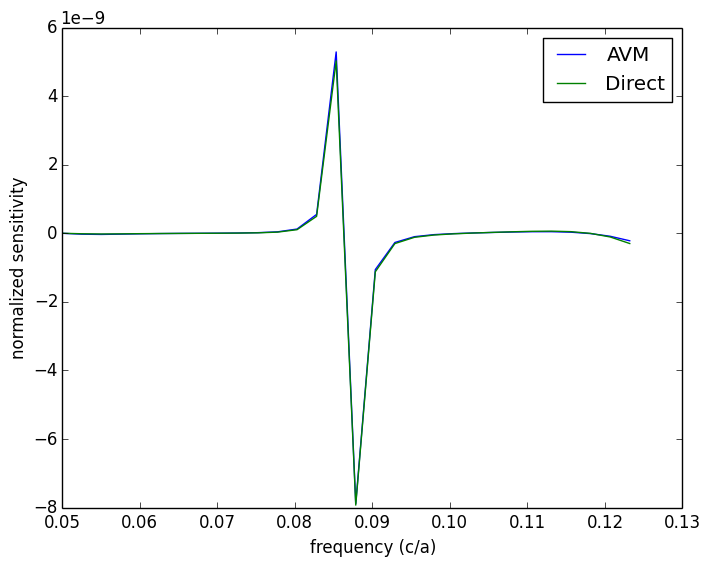

In [79]:
plot(freqs[1:30],imag(AVM_s[1:30]))
plot(freqs[1:30],Direct_s[1:30])
legend(("AVM","Direct"));
xlabel("frequency (c/a)");
ylabel("normalized sensitivity");

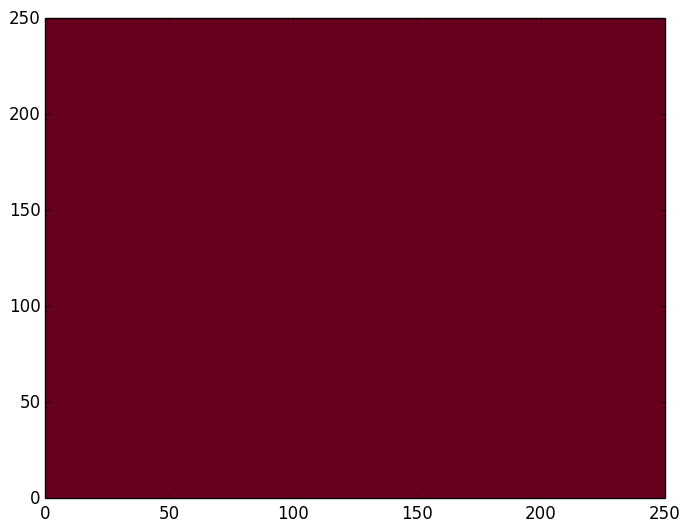

PyObject <matplotlib.collections.QuadMesh object at 0x31c922710>

In [68]:
#pcolormesh(real(Ez),cmap="RdBu",vmin=-0.0001,vmax=0.0001)
pcolormesh(imag(Ez.*Ez_AJ),cmap="RdBu")


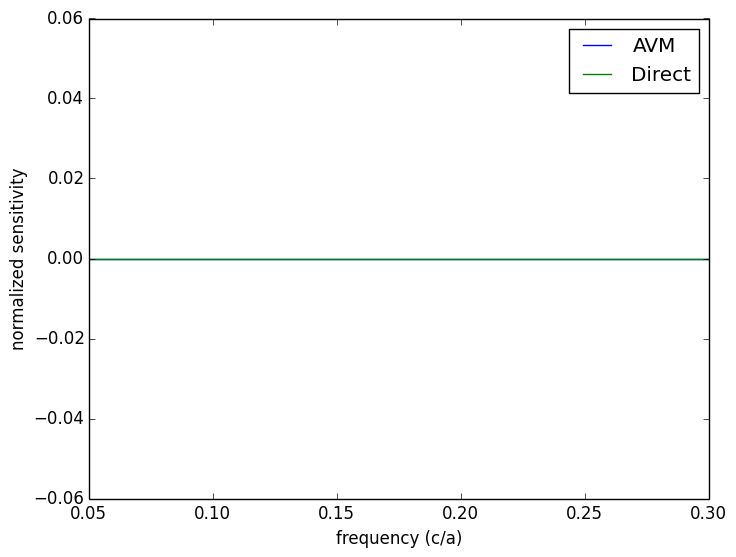

In [69]:
plot(freqs,-imag(AVM_s))
plot(freqs,Direct_s*10000)
legend(("AVM","Direct"));
xlabel("frequency (c/a)");
ylabel("normalized sensitivity");

In [83]:
E_obs = 1-im;
2im*conj(E_obs)

-2 + 2im